In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import torch

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:

import os
import sys
sys.path.append(f"{os.getcwd()}/../src")
import adv

In [12]:
def get_free_gpu():
    from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetCount
    nvmlInit()

    return np.argmax([
        nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(i)).free
        for i in range(nvmlDeviceGetCount())
    ])

if torch.cuda.is_available():
    cuda_id = get_free_gpu()
    device = 'cuda:%d' % (get_free_gpu(), )
    print('Selected %s' % (device, ))
else:
    device = 'cpu'
    print('WARNING: using cpu!')

### please, don't remove the following line
x = torch.tensor([1], dtype=torch.float32).to(device)

Selected cuda:1


## Load in the Z+Jets dataset:

In [13]:
ds = adv.ZJetsDataset(device=device, use_cache=True, dir="../data/adv")

n_train = int(0.8*len(ds))
n_val = len(ds)-n_train

ds_train, ds_val = torch.utils.data.random_split(ds, (n_train, n_val))

x_train, y_train = ds_train[:]
x_val, y_val = ds_val[:]

This dataset contains large-radius jets from a 50/50 mixture of two simulated LHC processes: the signal jets are from boosted Z->qq decays, while the background are QCD jets.
These correspond to labels y=1 and y=0, respectively.

The events are generated with MG5+Pythia8 with basic detector simulation by Delphes3. Jets are clustered from calorimeter towers with the anti-kT algorithm with radius parameter R=1.0. Momentum units are in TeV, which provides a reasonable normalization for working with neural networks.

The `x` tensors contain the 4-momenta in detector coordinates (pt, eta, phi) for up to 64 constituents comprising each jet. Therefore, the shape of the arrays are **(N, 64, 3)**, with the axes representing **(event, constituent, momentum coordinate)**.

Events with fewer than 64 particles are right-padded with zeros.

In [14]:
x_train.shape

torch.Size([640000, 64, 3])

Let's have a quick look at some of the data. For now we'll convert to numpy arrays for convenience:

In [15]:
x = x_val.cpu().numpy()
y = y_val.cpu().numpy()

xbg = x[y==0]
xsig = x[y==1]

First we'll plot the pt/eta/phi distributions for all particles over all events.
Notice there are more BG particles than signal; this is because the BG events tend to have more particles per jet.

Otherwise, there is not very much interesting information here.

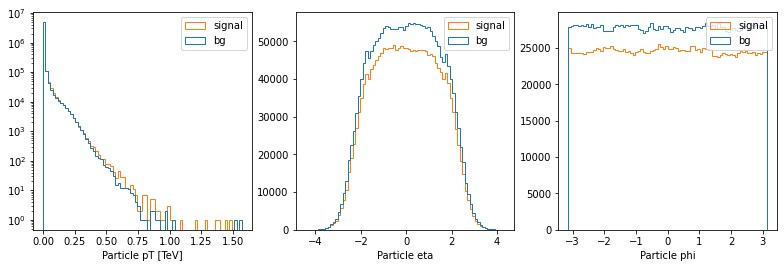

In [16]:
hargs = dict(histtype='step', bins=80, label=['bg','signal'])

plt.figure(figsize=plt.figaspect(0.3))
plt.subplot(131)
plt.hist([xbg[:,:,0].flatten(),xsig[:,:,0].flatten()], log=True, **hargs);
plt.xlabel("Particle pT [TeV]")
plt.legend();
plt.subplot(132)
plt.hist([xbg[:,:,1][xbg[:,:,0]>0],xsig[:,:,1][xsig[:,:,0]>0]], log=False, **hargs);
plt.xlabel("Particle eta")
plt.legend();
plt.subplot(133)
plt.hist([xbg[:,:,2][xbg[:,:,0]>0],xsig[:,:,2][xsig[:,:,0]>0]], log=False, **hargs);
plt.xlabel("Particle phi")
plt.legend();

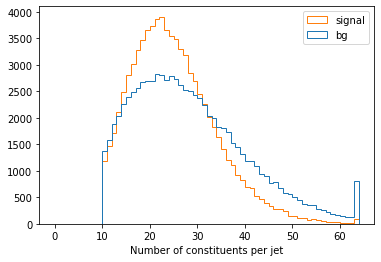

In [17]:
hargs = dict(histtype='step', bins=64, range=(0,64), label=['bg','signal'])
ntrk_bg = np.sum(xbg[:,:,0]>0, axis=-1)
ntrk_sig = np.sum(xsig[:,:,0]>0, axis=-1)
plt.hist([ntrk_bg, ntrk_sig], **hargs)
plt.xlabel("Number of constituents per jet")
plt.legend();

## Jet kinematics

It is more interesting to look at the basic jet-level kinematics. These are obtained by evaluated the 4-vector sum of the constituent particles' momenta. We have written a function in torch to do just that. It turns out this function is even differentiable, which as we shall see will be important later on.

The `to_jet()` method returns a (N, 4) tensor, containing the (pt,eta,phi,mass) of the combined jet cluster.

In [18]:
j = adv.to_jet(x_val)
jbg = j[y==0].cpu().numpy()
jsig = j[y==1].cpu().numpy()
print("j.shape:", j.shape)

j.shape: torch.Size([160000, 4])


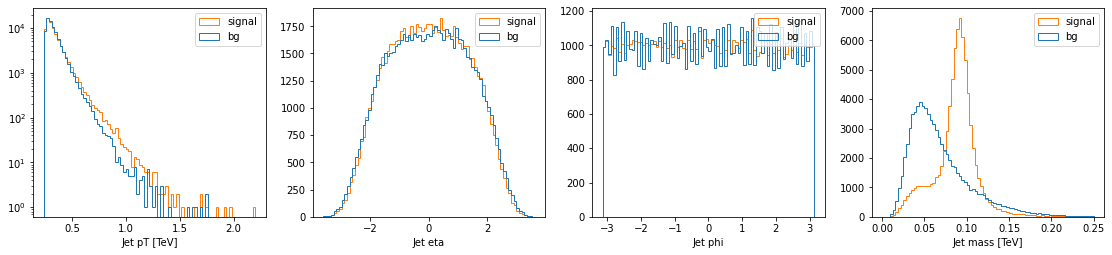

In [19]:
hargs = dict(histtype='step', bins=80, label=['bg','signal'])

plt.figure(figsize=1.2*plt.figaspect(0.2))
plt.subplot(141)
plt.hist([jbg[:,0],jsig[:,0]], log=True, **hargs);
plt.xlabel("Jet pT [TeV]")
plt.legend();
plt.subplot(142)
plt.hist([jbg[:,1],jsig[:,1]], log=False, **hargs);
plt.xlabel("Jet eta")
plt.legend();
plt.subplot(143)
plt.hist([jbg[:,2],jsig[:,2]], log=False, **hargs);
plt.xlabel("Jet phi")
plt.legend();
plt.subplot(144)
plt.hist([jbg[:,3],jsig[:,3]], log=False, range=(0,0.25), **hargs);
plt.xlabel("Jet mass [TeV]")
plt.legend();

Obviously the most striking feature is the resonance a the Z boson mass. However, since the BG rates are generally very high, there is a substantial amount of non-signal jets in this region as well. We hope that a neural network can help do a better job of disentangling them!

## Centering
Once we have the jet kinematics, we can "center" each event, by shifting the (eta, phi) of each particle so that the jet axis is at (0, 0).
Clearly the physics is invariant w.r.t. rotations in phi.
In general, however, shifting in eta corresponds to a lorentz-boost in the z-direction. Therefore, energy is not conserved in this transformation. However, the pT observable *is* invariant w.r.t. longitudnal boosts.

In [20]:
x_centered = adv.center_on(j, x_val).cpu().numpy()
cbg = x_centered[y==0]
csig = x_centered[y==1]

Notice the all the particles now have eta/phi values within +/- 1.0, corresponding to our jet radius parameter.

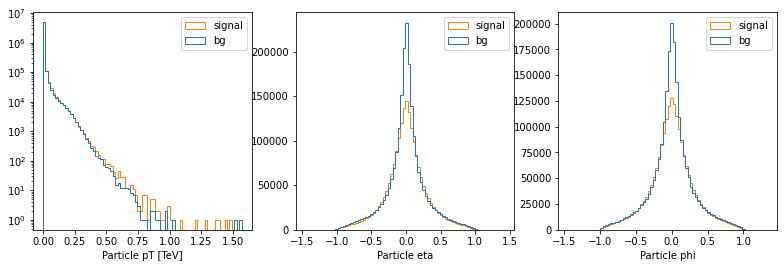

In [21]:
hargs = dict(histtype='step', bins=80, label=['bg','signal'])

plt.figure(figsize=plt.figaspect(0.3))
plt.subplot(131)
plt.hist([cbg[:,:,0].flatten(),csig[:,:,0].flatten()], log=True, **hargs);
plt.xlabel("Particle pT [TeV]")
plt.legend();
plt.subplot(132)
plt.hist([cbg[:,:,1][cbg[:,:,0]>0],csig[:,:,1][csig[:,:,0]>0]], log=False, **hargs);
plt.xlabel("Particle eta")
plt.legend();
plt.subplot(133)
plt.hist([cbg[:,:,2][cbg[:,:,0]>0],csig[:,:,2][csig[:,:,0]>0]], log=False, **hargs);
plt.xlabel("Particle phi")
plt.legend();

We can also now make a 'composite' image of many jets:

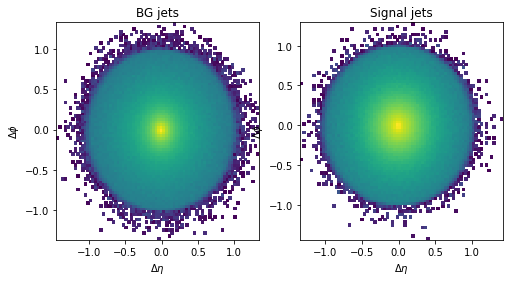

In [22]:
from matplotlib.colors import LogNorm
plt.figure(figsize=plt.figaspect(0.5))
plt.subplot(121)
plt.hist2d(cbg[:,:,1][cbg[:,:,0]>0], cbg[:,:,2][cbg[:,:,0]>0], weights=cbg[:,:,0][cbg[:,:,0]>0], bins=80, norm=LogNorm(), density=True);
plt.xlabel(r"$\Delta\eta$");
plt.ylabel(r"$\Delta\phi$");
plt.title("BG jets")
plt.subplot(122)
plt.hist2d(csig[:,:,1][csig[:,:,0]>0], csig[:,:,2][csig[:,:,0]>0], weights=csig[:,:,0][csig[:,:,0]>0], bins=80, norm=LogNorm(), density=True);
plt.xlabel(r"$\Delta\eta$");
plt.ylabel(r"$\Delta\phi$");
plt.title("Signal jets");

Lastly, we can inspect some individual jets as well. In the below figures, we see individual jets' particles in the eta-phi plane, centered about the jet axis.

The color and size represent particle pT (larger,yellow -> higher pT, smaller,red -> lower pT).

Would you be able to tell apart individual signal from BG jets based on these representations? That's what we're going to ask the neural network to do!

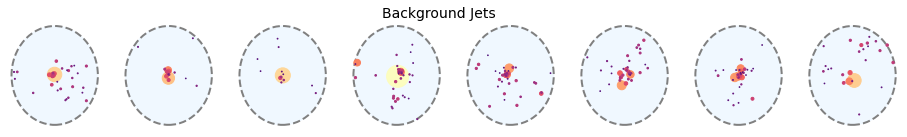

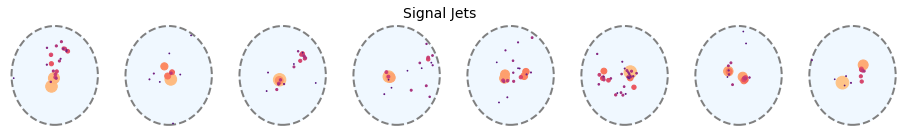

In [23]:
nshow = 8

plt.figure(figsize=plt.figaspect(1/nshow))
for i in range(nshow):
    j0 = cbg[i][cbg[i,:,0]>0]

    plt.subplot(1, nshow, i + 1)
    plt.gca().add_artist(plt.Circle((0,0),1,color='aliceblue'))
    plt.gca().add_artist(plt.Circle((0,0),1,ls='--',lw=2,color='gray',fill=False))
    plt.scatter(j0[:,1], j0[:,2], s=(j0[:,0]*1e3), cmap='magma', c=np.log(j0[:,0]), vmin=np.log(5e-5), vmax=np.log(0.5),zorder=2)
    plt.gca().axis('off')
    plt.xlim(-1.1,1.1)
    plt.ylim(-1.1,1.1)
plt.suptitle("Background Jets", fontsize=14)

plt.figure(figsize=plt.figaspect(1/nshow))
for i in range(nshow):
    j1 = csig[i][csig[i,:,0]>0]
    
    plt.subplot(1, nshow, i + 1)
    plt.gca().add_artist(plt.Circle((0,0),1,color='aliceblue'))
    plt.gca().add_artist(plt.Circle((0,0),1,ls='--',lw=2,color='gray',fill=False))
    plt.scatter(j1[:,1], j1[:,2], s=(j1[:,0]*1e3), cmap='magma', c=np.log(j1[:,0]), vmin=np.log(5e-5), vmax=np.log(0.5),zorder=2)
    plt.gca().axis('off')
    plt.xlim(-1.1,1.1)
    plt.ylim(-1.1,1.1)
plt.suptitle("Signal Jets", fontsize=14);